# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

The simulation runs in discrete steps, each step represents a decision at an intersection for the agent to make. The agent can choose to stay put, move forward, go left or go right. There can be oncoming traffic from the three other roads leading into the four way intersections, and there can be a green light for east-west or north-south, with a red light for the other. The destination is marked with an Udacity symbol, but the agent is running without knowledge about the destination.

The agent is currently always choosing not to move. Sometimes it gets a slight reward for not moving, if there was a red light and it were supposed to go forward or left. But more often, it is punished relatively hard for not moving "with no oncoming traffic". I never saw it being rewarded for not moving while when there actually was oncoming traffic.

**UPDATE:** 

Consider the situation described in the safty rating D: "Agent causes at least one minor accident, such as turning left on green with oncoming traffic.". It turned out that the reward structure was not correctly punishing left turns with dangerous oncoming traffic and a green light. This was fixed in the following commit: https://github.com/udacity/machine-learning/commit/912f9edbb2c6647039cf71c42f0f075d842b273e

But the commit above introduced additional issues, such as being punished for waiting for oncoming traffic when you were supposed to turn left. It was considered a minor violation to wait. I believe I have fixxed these issues in my pull request: https://github.com/udacity/machine-learning/pull/268

Only my simulations with the improved agent has been run with the new and correct environment rewards.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

**Agent.py - three flags explained**

* *num_dummies* - this seems to indicate how many other cards are driving around simultaneously, the default value is 100, but more relevant might be to know that it is about 2 cars per intersection on average.
* *grid_size* - this seems to indicate how big the world is, and assuming that the destination is random point in the world, how far away the target might end up.
* *learning* - can force the agent to use Q-learning by being set to True, I presume the alternative is to simply utilize a model without improving on it by learning. If Q-learning is enabled, the Q-values will be updated.

**enviroment.py - what Environment class function is called when an agent performs an action?**

The following function, I conclude this based on the comment and the parameters passed to the function.

```python
def act(self, agent, action):
    """ Consider an action and perform the action if it is legal.
        Receive a reward for the agent based on traffic laws. """
```

**simulator.py - *render_text()* vs *render()***

It renders output for either the terminal/command prompt or GUI versions of the simulation.

```python
def render_text(self, trial, testing=False):
    """ This is the non-GUI render display of the simulation. 
        Simulated trial data will be rendered in the terminal/command
        prompt. """
```

```python
def render(self, trial, testing=False):
    """ This is the GUI render display of the simulation. 
        Supplementary trial data can be found from render_text. """
```

**planner.py - will the 'next_waypoint() function consider the North-South or East-West direction first?**

The East-West direction, it pleases me aesthetically since it is associated with *x* rather than *y*, which is the latter in the alphebet.

```python
    # ... snippet from line 38-39 ...
    # Next check if destination is cardinally East or West of location    
    elif dx != 0:
    # ...
```

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


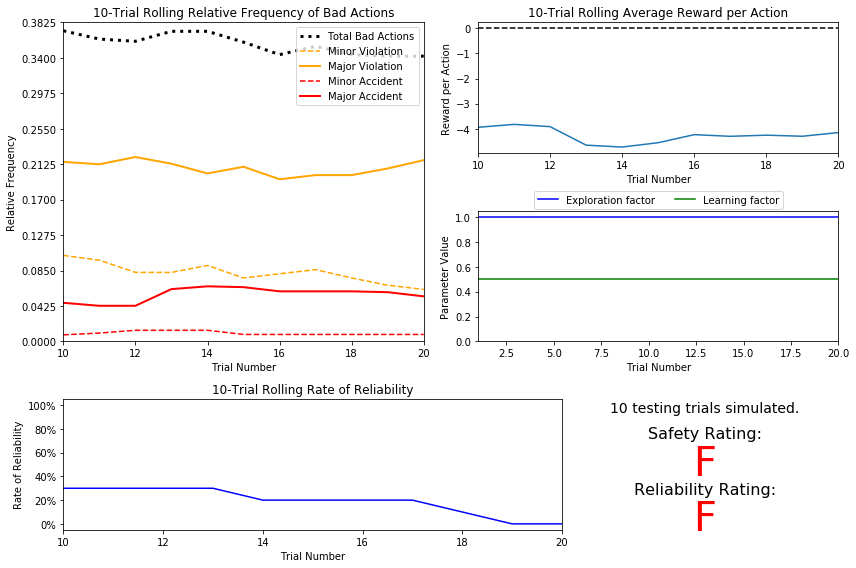

In [2]:
# NOTE: The '_notebook' suffix is to ensure I don't overwrite the logs I've discussed.
# NOTE: I updated the visualization code to be able to give a one line summary instead.
#       The current output is exactly identical though.

# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning_notebook.csv', print_instead_of_plot=False)

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:** 

First some terminology deciphering, the top left panel is titled '10-trial rolling relative frequency of bad actions'. That first part with rolling means that each data point is an average of 10-trials, selected with a sliding window. If we take the average of the first and the last point in a given panel, we will get the average of all 20 trials.

**Top left panel:**

At this stage I don't care very much about the red lines, since I figure they mainly are a consequence of the rate of violations in combination with the density of other cars. There seem to be about 10% minor violations and 20% major violations, resulting in a total of 30% risk of making a violation. Oh but I must also add the accidents to this, so a total of about 36% of the actions are bad and about 5% of all actions lead to accidents.

**Top right panel:**

The current reward per action is at about -4. It is being penalized a lot, since the penalties were about -5 and the rewards were about +1, most of the actions must have led to punishment.

**Bottom left panel:**

The rate of reliability is exactly 15% in this simulation, that means that the car arrived at the destination 3 times out of 20. How likely should this be with our model? Well there is $8*6=48$ intersections on the screen, and you start at one, and I presume any of the remaining 47 interactions is chosen uniformly at random to be the destination. Also, 25% of the actions should on average be to stand still, and during the remaining 15 movements, you might crash and that probably causes the simulation to end. So perhaps you only make an average of about say 10 moves, and some of those will end come back to previously visited intersections - is it plausible that you react 7 new or more on average, which represents about 15% of the 47 that could be the destination? Yes I think this is plausible.

**General observations:**

Using 20 trials with 10-trail rolling averages seems very reasonable for the top panels, most of the random fluctuations seem to have smoothed out to a great extent. For the bottom panel, the confidence interval is biggest, since we simply have twenty binary data points in this graph, while the others have twenty data points that in turn are created by averages - a reasoning using the Central Limit Theorem.

This smartcab would obviously not be considered safe, as a random choice is obviously not safe, and major accidents tend to happen very often considering how dangerous they are.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

TL;DR: *inputs['right']* and *deadline* is deemed pointless features in order to get A+ rating and find the optimal policy. *Inputs['left']* is only required in order to make safe right turns at red lights, one could consider trimming away this as well.

As I understand it, the *inputs['right']* is pointless information if you plan to follow the traffic rules. It has a point if you consider breaking them and run a red light left or forward in order to save time though, but this is nothing to plan for if we strive for consistent A+ ratings anyhow.

If we had knowledge of the actual destination rather than just a single waypoint, a few edge cases would arise where *deadline* could be relevant - I think it could be used to maximize the likelyhood of making it in time instead of minimizing the average time, two things that I think most of the time will be the same but might not always be. But as *waypoint* is reduced to one discrete movement by the planner, my current hypothesis is that *deadline* is a pointless feature.

Note that *inputs['oncoming']* was actually not required before the code update mentioned in Question 1's answer, as the environment did not have an issue with turning left while there was oncoming traffic to crash into. But I realized this and figured something was wrong, and thereafter found the code update.

**For my own reference:**

I made a simplified policy like table that did not include *waypoint* directly, mostly for my own processing of the traffic rules but also for future reference. Note that the do nothing action might be okay depending on *waypoint*.

|State:| Light | Oncoming | Left  |Action:|Do nothing|Go forward|Turn left |Turn right|
|------|-------|----------|-------|-------|----------|----------|----------|----------|
|      | Green | None     | None  |       | STUPID   | OK       | OK       | OK       |
|      | Green | None     | Other |       | STUPID   | OK       | OK       | OK       |
|      | Green | Other    | None  |       | OK (~O_L)| OK       | OK (O_L) | OK       |
|      | Green | Other    | Other |       | OK (~O_L)| OK       | OK (O_L) | OK       |
|      | Red   | None     | None  |       | OK (~W_R)| DANGER   | DANGER   | OK       |
|      | Red   | None     | Other |       | OK (...) | DANGER   | DANGER   | OK (~L_F)|
|      | Red   | Other    | None  |       | OK (...) | DANGER   | DANGER   | OK (~O_L)|
|      | Red   | Other    | Other |       | OK (...) | DANGER   | DANGER   | OK (...) |

**Interpretation example:**

OK (~O_L) means that it could be a plausible action for some waypoint assuming there was no (~) oncoming (O) traffic travelling to the left (L).

OK (~W_R) means that it could be a plausible action for some waypoint assuming it was not (~) the waypoint (W) to the right (R).

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

My state space consists of $3 \cdot 2 \cdot 4 \cdot 4 = 96$ states. This will work out great I think, at least if we make sure it can fail fast by being punished for misbehaviour, I write this imagining that if you trained it without much traffic, and required it to crash some times in order to learn, that might take too much time. Anyhow, it is good we do not need to multiply two more factors of $4$ and $20$, then we would have had a total of $96 \cdot 4 \cdot 20 = 7680$ states. Pweh!

By the way, these features are now also sorted in order of the relevance I believe them to have.

||Selected features | # substates
|-
||*waypoint*| 3
||*light*   | 2
||*oncoming*| 4
||*left*    | 4

||Left out features | # substates 
| -
||*right*          | 4
||*deadline*       | 20

|<td colspan="2"><strong>Total number of states</strong></td>
| -
|| Before selection | 7680
|| After selection  | 96

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

Linear-Epsilon-0.05-Decrements-learning implementation results (Default learning)



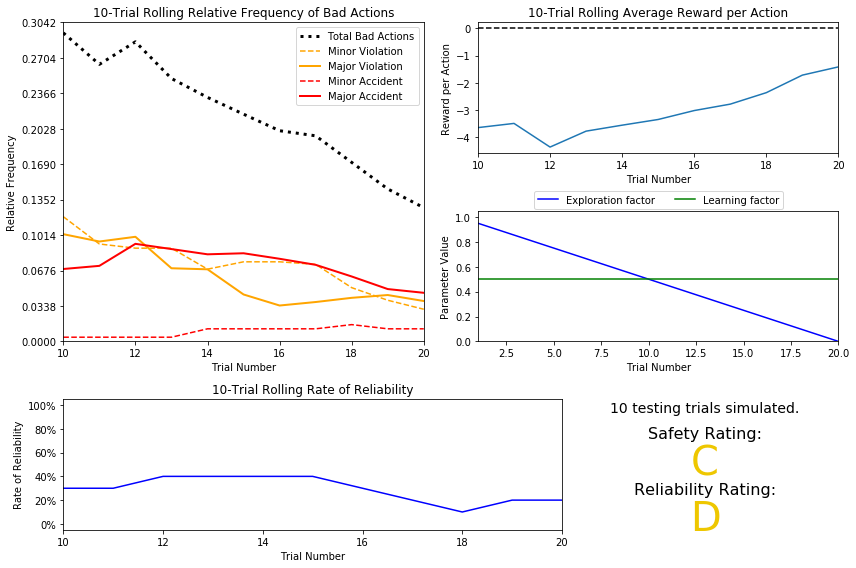

Linear-Epsilon-0.01-Decrements-learning implementation results



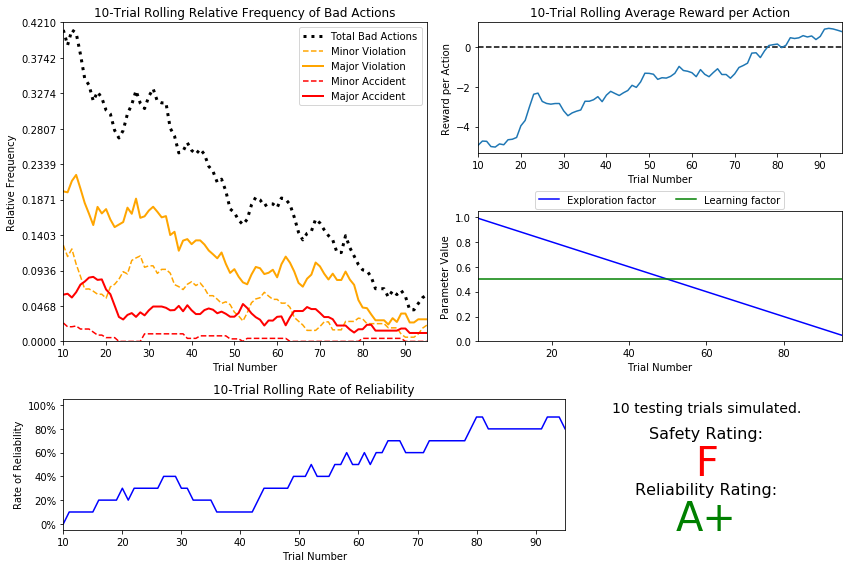

Linear-Epsilon-0.001-Decrements-learning implementation results



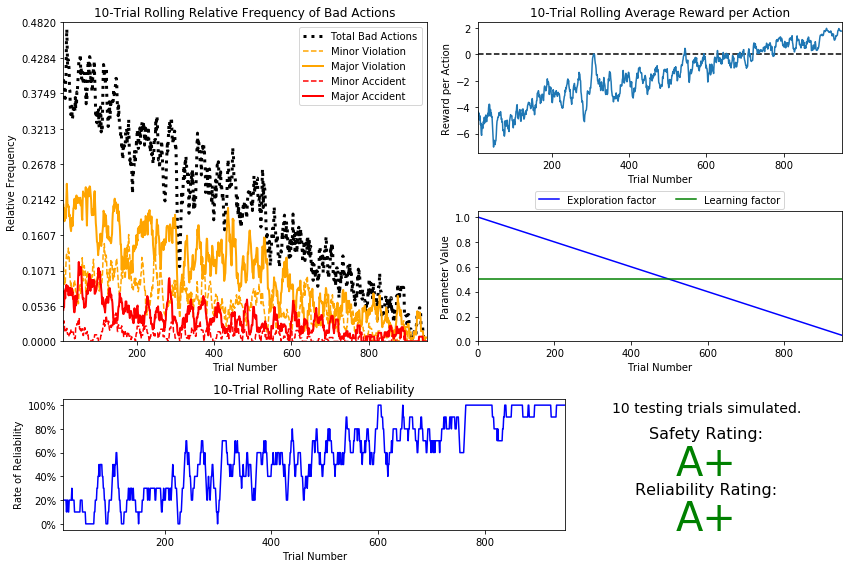

In [3]:
# NOTE: The '_notebook' suffix is to ensure I don't overwrite the logs I've discussed.
# NOTE: These logs are made before the code update discussed in Question 1's answer.

#print "No-learning implementation results\n"
#vs.plot_trials('sim_no-learning_notebook.csv')

# Load the 'sim_default-learning' file from the default Q-Learning simulation
print "Linear-Epsilon-0.05-Decrements-learning implementation results (Default learning)\n"
vs.plot_trials('sim_linear-epsilon-0.05-decrements-learning.csv')

print "Linear-Epsilon-0.01-Decrements-learning implementation results\n"
vs.plot_trials('sim_linear-epsilon-0.01-decrements-learning.csv')

print "Linear-Epsilon-0.001-Decrements-learning implementation results\n"
vs.plot_trials('sim_linear-epsilon-0.001-decrements-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:** 

After the initial training results showed, I figured we should simply train the model a bit more thoroughly, as the *total bad actions* and *average reward per action* were improving steadily. $\epsilon$ (epsilon) is the likelyhood of exploring actions at random (named *Exploration factor* in a graph to the right), it was supposed to be decreasing linearly from its initial value of 1 in steps of 0.05 until it reached the default threshold of 0.05, so it would run for 20 trials. I tuned this decrement of $\epsilon$ since that would result in a more thorough exploration of the state space (N=96). I'm thinking that if the algorithm would explore each state and try each potential action (N=4), it might very well converge to an optimal policy - there are $96 \cdot 4 = 384$ different rewards to learn from. Anyhow, I let it run for 1000 trails, each of which probably let the algorithm experience roughly ten outcomes, and by doing that I achieved the best rating.

| Decrement steps | Total trials\* | Saftey | Reliability
|-
|0.05 | 19  | C  | D
|0.01 | 95  | F  | A+
|0.001| 950 | A+ | A+

\* Why 95 and 950 and not 100 and 1000? It is because I did not update the threshold value, it were always at 0.05. So I figured it would run for $(1 - t) / d$ steps where $d$ is the linear decriment step size and $t$ is the threshold value for $\epsilon$ - makes sense? You can try it out with $d=0.05$ and $t=0.05$, then think of it as needing to take 19 decriments from 1 to reach 0.05, represented by (1 - 0.05) / 0.05.

**Comparision to the no-learning agent:**

We'll reasonably except that both agents behaved similarly on the initial trials, where the learning agent is exploring and hence also picking random actions just as the no-learning agent is. Other than that, I would not consider anything else similar between the no-learning agent and the learning agents, unless one would consider the common learning factor of 0.5, but that would be silly, since it never is used by the no-learning agent anyhow, as it's always exploring and making random actions.

**Miscellaneous observations and discussion:**

The *total number of bad actions* had a decreasing trend in all of the models I trained, and similarly the *average reward per action* in all models were all showing an increasing trend with additional experience in each model.

There were always only ten testing trials (*n_test*=10), I noticed that the variations in saftey and reliability rating were noticable even though the same model tended to land on similar *average reward per action* after training. Before considering the best trained model safe, I would run an really massive test. If this were a more realistic situation, it would be great to test it to the point humans would fail often, and see if it would not fail where humans would. In this simple model, we could simply ensure that it would not cause an accident in any of the 96 states, and then see that it performed ran reliably as well.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

Exploit 5 - n:500 t:100 a:1 ed:T o:True

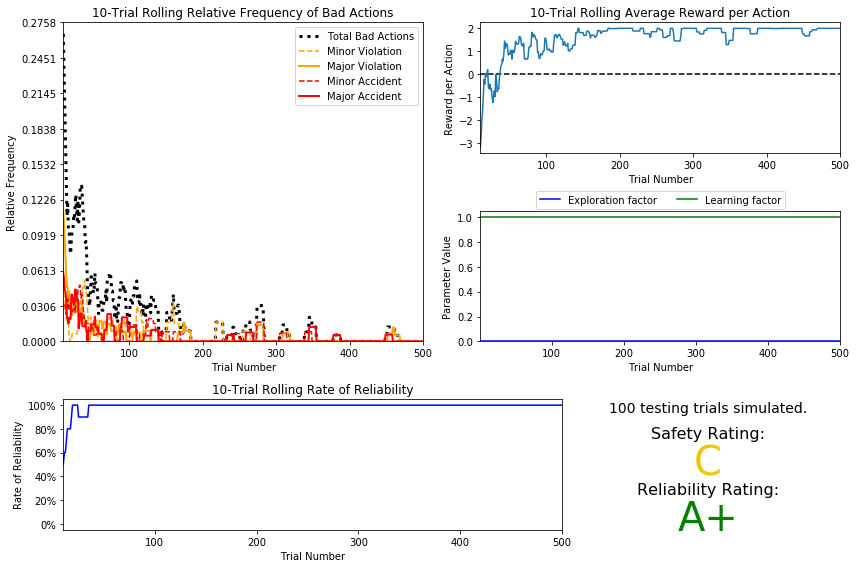


Exploit 5 - n:1000 t:100 a:1 ed:T o:True

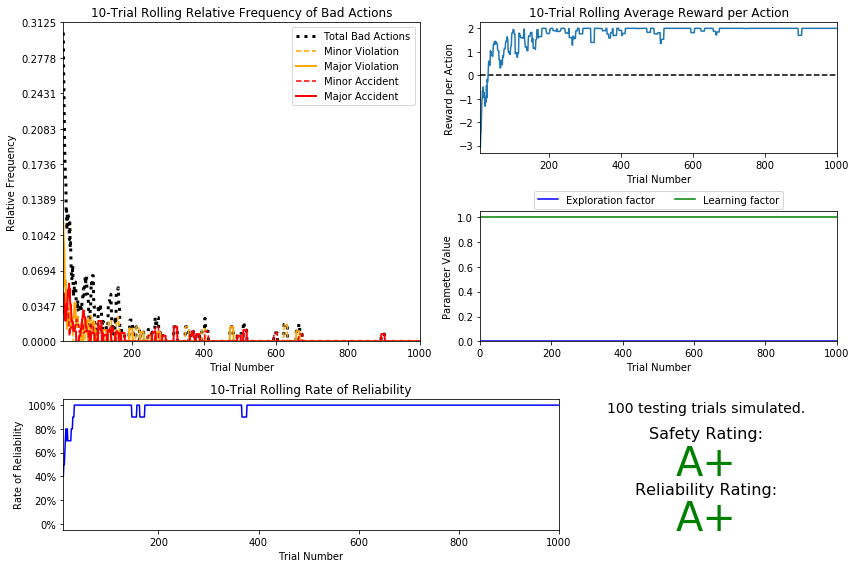

In [27]:
import visuals as vs

# NOTE: --- CAUTION PLEASE READ ---
#       I tried out adjustments outside the scope of the instructions in these simulations...
#       But, I also made an optimized agent within the scope of the instructions in the Jupyter cell below.
#
#       In this simulation though, I adjusted a lot of things, for example...
#       1: I set the initial Q values to 10 and was always exploiting in order to explore
#          all possible actions once with an learning rate of 1.
#       2: I made the rewards deterministic by removing a random initialization.
#          https://github.com/udacity/machine-learning/issues/269
#       3: Various additional details...

# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
# NOTE: I modeled various functions, they can be viewed in the following link.
#       https://www.desmos.com/calculator/uydpkrogmm
simulation_files = [
    #{'Explore 5':'sim_explore-5'},
    #{'Explore 4':'sim_explore-4'},
    #{'Explore 3':'sim_explore-3'},
    #{'Explore 2':'sim_explore-2'},
    #{'Explore 1':'sim_explore-1'},
    #{'Neutral 0':'sim_neutral'},
    #{'Exploit 1':'sim_exploit-1'},
    #{'Exploit 2':'sim_exploit-2'},
    #{'Exploit 3':'sim_exploit-3'},
    #{'Exploit 4':'sim_exploit-4'},
    {'Exploit 5':'sim_exploit-5'},
]

optimized = [True]
n_trainings = [500, 1000] # 100, 250, 500, 1000
n_tests = [100] # 100
alphas = [1] # 1
enforce_deadlines = [True]
print_instead_of_plot = False

for simulation in simulation_files:
    for n in n_trainings:
        for o in optimized:
            for ed in enforce_deadlines:
                for t in n_tests:
                    for a in alphas:
                        print '{} - n:{} t:{} a:{} ed:{} o:{}'.format(simulation.keys()[0], n, t, a, str(ed)[0], o),
                        vs.plot_trials(simulation.values()[0]+'_train-'+str(n)+'_test-'+str(t)+'_alpha-'+str(a)+'_enforce-deadline-'+str(ed)+'_optimized-env-'+str(o)+'.csv', print_instead_of_plot=print_instead_of_plot)
        print

 Neutral 0 - n:500 t:100 a:0.5 ed:T o:False

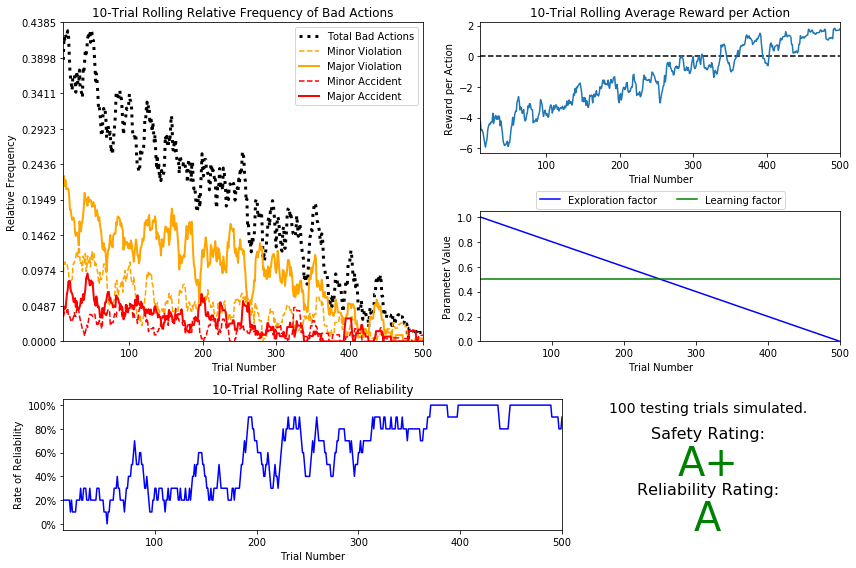


Neutral 0 - n:1000 t:100 a:0.5 ed:T o:False

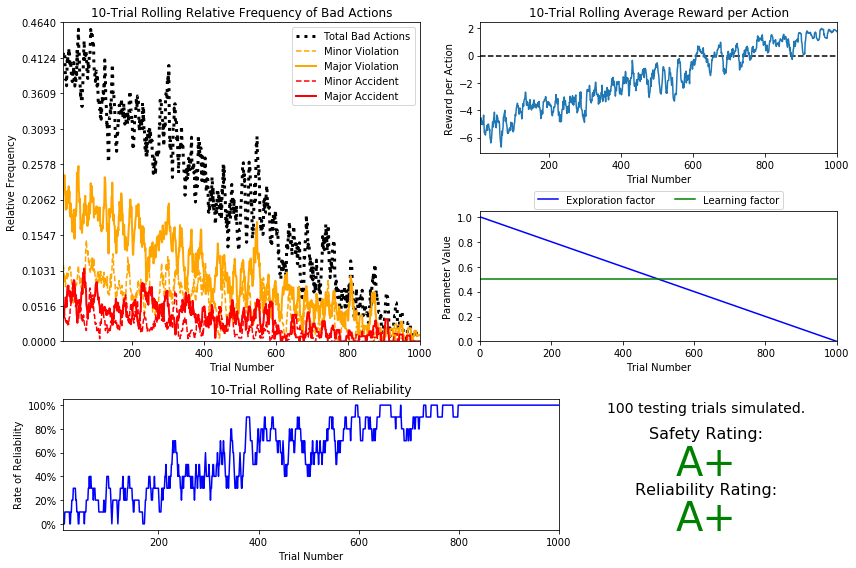


Neutral 0 - n:2000 t:100 a:0.5 ed:T o:False

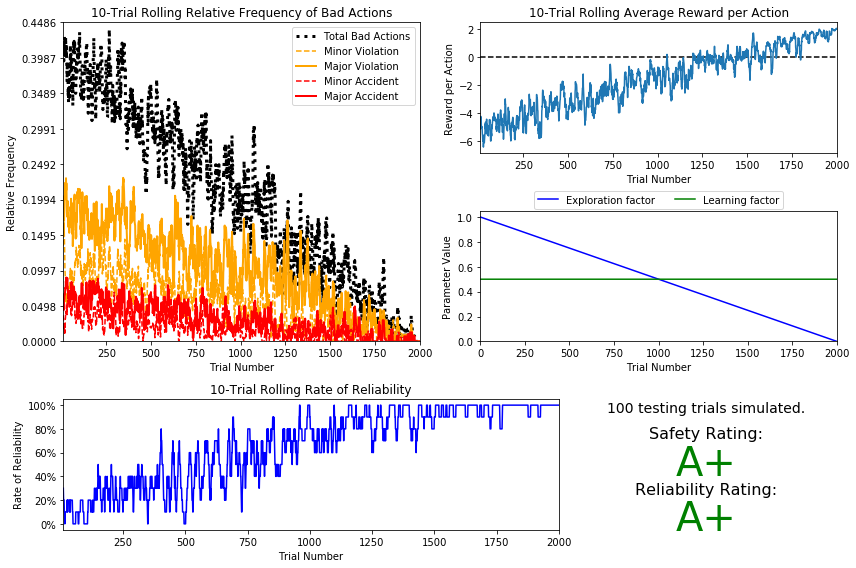

In [32]:
# NOTE: These simulations are made without modifi

simulation_files = [
    #{'Explore 5':'sim_explore-5'},
    #{'Explore 4':'sim_explore-4'},
    #{'Explore 3':'sim_explore-3'},
    #{'Explore 2':'sim_explore-2'},
    #{'Explore 1':'sim_explore-1'},
    {'Neutral 0':'sim_neutral'},
    #{'Exploit 1':'sim_exploit-1'},
    #{'Exploit 2':'sim_exploit-2'},
    #{'Exploit 3':'sim_exploit-3'},
    #{'Exploit 4':'sim_exploit-4'},
    #{'Exploit 5':'sim_exploit-5'},
]

optimized = [False]
n_trainings = [500, 1000, 2000] # 100, 250, 500, 1000
n_tests = [100] # 100
alphas = [0.5] # 1
enforce_deadlines = [True]
print_instead_of_plot = False

for simulation in simulation_files:
    for n in n_trainings:
        for o in optimized:
            for ed in enforce_deadlines:
                for t in n_tests:
                    for a in alphas:
                        print '{} - n:{} t:{} a:{} ed:{} o:{}'.format(simulation.keys()[0], n, t, a, str(ed)[0], o),
                        vs.plot_trials(simulation.values()[0]+'_train-'+str(n)+'_test-'+str(t)+'_alpha-'+str(a)+'_enforce-deadline-'+str(ed)+'_optimized-env-'+str(o)+'.csv', print_instead_of_plot=print_instead_of_plot)
        print

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

To answer these questions, I need to establish some observations:

1. In order for the agent to learn, it needs experience from the intersections. But if it is exploiting a lot, it will reach its destination faster and run experience fewer intersections in its trials. This means that epsilon decay functions that is very explorative overall will get to learn from more intersections than exploitative. This means that evaluation of the decay function based on the score without considering the time it took to run is misleading.

UPDATE: Perhaps not an issue, but feels a bit awkward that the amount of intersections experienced is a indirect function of the epsilon decay function: https://github.com/udacity/machine-learning/issues/270

2. The rewards are apparently not deterministic (why!?), consider the code referenced below from environment.py... Note that the reward is initiated in a range of width 2, this means that the optimal action may by chance be rewarded less than an inoptimal action! This makes it relevant to utilize an alpha value, so that the highest Q-value action isn't quickly replaced. A lower than one alpha protects us from a sudden change in policy due to random flukes but doesn't guarantee reaching an optimal policy. For further discussion about this, see the links in the code below.

UPDATE: About this random initialization of rewards: https://github.com/udacity/machine-learning/issues/269

3. The environment was not very optimal for this agent to learn the optimal policy, and if I could change it, I would. 

```python
"""
This is a code excert from the 'act' function in the Environment class.

For additional discussion, see the entries I make (Erik Sundell) in the replies to this post.
 - https://discussions.udacity.com/t/is-there-a-reason-that-the-reward-has-a-random-portion-in-it/327823
"""

# First initialize reward uniformly random from [-1, 1]
reward = 2 * random.random() - 1

# ...

# Agent wants to drive right:
elif action == 'right':
    if light != 'green' and inputs['left'] == 'forward': # Cross traffic
        violation = 3 # Accident
    else: # Valid move!
        heading = (-heading[1], heading[0])

# ...

# Did the agent attempt a valid move?
if violation == 0:
    if action == agent.get_next_waypoint(): # Was it the correct action?
        reward += 2 - penalty # (2, 1) --- NOTE: Net reward: (3, 0)
        # OPTIMAL: Agent moved towards the waypoint meanwhile following the laws and no traffic disturbed the action.
    elif action == None and light != 'green' and agent.get_next_waypoint() == 'right':
        # NON-OPTIMAL: valid action but incorrect (idling at red light, when we should have gone right on red)
        reward += 1 - penalty # (1, 0) --- NOTE: Net reward: (2, -1)
    # ...
```

Now I'll answer the questions.

I made two optimized agents, one without messing around in environment.py etc, and one when I did, mainly to understand everything better. Let me discuss the one where i didn't mess with environment.py more than correcting a bug in the reward implementation: https://github.com/udacity/machine-learning/pull/268

The choice of epsilon decay function (the exploration factor decay function).
I utilized a linear epsilon decay function, I tested many others, and they all did the job quite well if they were about linear or slightly exploitative. These are the decay functions I tested: https://www.desmos.com/calculator/uydpkrogmm

I also considered various alpha values. Initially I presumed that the rewards were deterministic, but they were not, and even the reward ranking between actions could change. Hence: if you would make a exploration in the end of the training which happened to give a reward for a non-optimal policy that was higher than the optimal, you would not end up with an optimal policy. So, because of this, one should perhaps choose a lower alpha, say 0.5 and be a bit exploitative in order to build up strength in the good actions Q-values from the initial value of 0.

I needed about 1000 trials in order to get a A+/A+ rated policy, but I would need about 5000 trials in order to find the optimal policy with a neutral epsilon decay function I believe. After both 1000 and 2000 trials, all but one state to action mapping was optimal. I updated my simulator.py file to output more readable log files. See for example *sim_neutral_train-1000_test-100_alpha-0.5_enforce-deadline-True_optimized-env-False.txt*.

When I used my optimized agent that was trained by different Q-value initializations and removed the random reward initialization, I could find the optimal policy in about 1000 trials (instead of about 5000).

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

**The optimal policy:**

I theorized what the optimal policy should be and made a table below that maps states to actions. / means *or*, - means *all*, L, R and F means Left, Right and Forward and N represents no action. The optimal action given a state is either to drive in the waypoint direction or stay put and wait.

| Light | Waypoint | Oncoming| Left  | Action|
|-------|----------|---------|-------|-------|
| Green | F/R      | -       | -     | Drive |
| Green | L        | N/L     | -     | Drive |
| Green | L        | F/R     | -     | Wait  |
| Red   | L/F      | -       | -     | Wait  |
| Red   | R        | -       | F     | Wait  |
| Red   | R        | -       | L/N/R | Drive |

Without modifying the environment.py file, I almost found the optimal policy. But my agent had not explored all possible actions for all possible states after 1000 trials or 2000 trials, and ended up going right instead of waiting to turn left in a given circumstance, as seen in the log snippet below. Had I run for about 5000 trials, I believe it would be probably that it had explored the outcome of that action as well and found the optimal policy.

```
/-----------------------------------------
| State-action rewards from Q-Learning (1000 trials - I did not modify environment.py)
| States: 96, state actions: 384, **unexplored state actions: 5**
| State tuple: (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
\-----------------------------------------

NOTE: The letters N, F, L and R to the left represents the recommended action for the given
      state and ! means that the action matches my theoretical optimal policy.

...

R! : ('right', 'red', 'forward', 'right')          F:-25.06, R: 2.21, N: 0.49, L:-17.38
R  : ('left', 'green', 'forward', None)            F: 0.81, R: 1.40, N: 1.23, L:-20.29
N! : ('left', 'green', 'forward', 'forward')       F: 1.22, R: 0.80, N: 2.05, L:-19.59

...

/-----------------------------------------
| State-action rewards from Q-Learning (2000 trials - I did not modify environment.py)
| States: 96, state actions: 384, **unexplored state actions: 2**
| State tuple: (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
\-----------------------------------------

...

```

From the three log outputs above which I made more readable for my own sake, the explanation mark denotes that it is considered the optimal policy. The middle entry was not optimal as turning Right when you could wait instead in order to turn left is probably considered even better.

The Last entry represents waiting for cross traffic when about to turn left (optimal), and the first entry represent turning Right (optimal) when there is no traffic hindering a right turn even though the lights are red.


```
/-----------------------------------------
| State-action rewards from Q-Learning (1000 trials - I did modify environment.py)
| States: 96, state actions: 384, **unexplored state actions: 0**
| State tuple: (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
\-----------------------------------------

NOTE: The letters N, F, L and R to the left represents the recommended action for the given
      state and ! means that the action matches my theoretical optimal policy.

F! : ('forward', 'green', None, None)              F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', None, 'forward')         F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', None, 'left')            F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', None, 'right')           F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', 'forward', None)         F: 2.00, R: 1.00, N:-5.00, L:-20.00
F! : ('forward', 'green', 'forward', 'forward')    F: 2.00, R: 1.00, N:-5.00, L:-20.00
F! : ('forward', 'green', 'forward', 'left')       F: 2.00, R: 1.00, N:-5.00, L:-20.00
F! : ('forward', 'green', 'forward', 'right')      F: 2.00, R: 1.00, N:-5.00, L:-20.00
F! : ('forward', 'green', 'left', None)            F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', 'left', 'forward')       F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', 'left', 'left')          F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', 'left', 'right')         F: 2.00, R: 1.00, N:-5.00, L: 1.00
F! : ('forward', 'green', 'right', None)           F: 2.00, R: 1.00, N:-5.00, L:-20.00
F! : ('forward', 'green', 'right', 'forward')      F: 2.00, R: 1.00, N:-5.00, L:-20.00
F! : ('forward', 'green', 'right', 'left')         F: 2.00, R: 1.00, N:-5.00, L:-20.00
F! : ('forward', 'green', 'right', 'right')        F: 2.00, R: 1.00, N:-5.00, L:-20.00
N! : ('forward', 'red', None, None)                F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('forward', 'red', None, 'forward')           F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('forward', 'red', None, 'left')              F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('forward', 'red', None, 'right')             F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('forward', 'red', 'forward', None)           F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('forward', 'red', 'forward', 'forward')      F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('forward', 'red', 'forward', 'left')         F:-10.00, R: 1.00, N: 2.00, L:-40.00
N! : ('forward', 'red', 'forward', 'right')        F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('forward', 'red', 'left', None)              F:-10.00, R: 1.00, N: 2.00, L:-40.00
N! : ('forward', 'red', 'left', 'forward')         F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('forward', 'red', 'left', 'left')            F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('forward', 'red', 'left', 'right')           F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('forward', 'red', 'right', None)             F:-40.00, R: 1.00, N: 2.00, L:-40.00
N! : ('forward', 'red', 'right', 'forward')        F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('forward', 'red', 'right', 'left')           F:-40.00, R: 1.00, N: 2.00, L:-40.00
N! : ('forward', 'red', 'right', 'right')          F:-10.00, R: 1.00, N: 2.00, L:-40.00
L! : ('left', 'green', None, None)                 F: 1.00, R: 1.00, N:-5.00, L: 2.00
L! : ('left', 'green', None, 'forward')            F: 1.00, R: 1.00, N:-5.00, L: 2.00
L! : ('left', 'green', None, 'left')               F: 1.00, R: 1.00, N:-5.00, L: 2.00
L! : ('left', 'green', None, 'right')              F: 1.00, R: 1.00, N:-5.00, L: 2.00
N! : ('left', 'green', 'forward', None)            F: 1.00, R: 1.00, N: 2.00, L:-20.00
N! : ('left', 'green', 'forward', 'forward')       F: 1.00, R: 1.00, N: 2.00, L:-20.00
N! : ('left', 'green', 'forward', 'left')          F: 1.00, R: 1.00, N: 2.00, L:-20.00
N! : ('left', 'green', 'forward', 'right')         F: 1.00, R: 1.00, N: 2.00, L:-20.00
L! : ('left', 'green', 'left', None)               F: 1.00, R: 1.00, N:-5.00, L: 2.00
L! : ('left', 'green', 'left', 'forward')          F: 1.00, R: 1.00, N:-5.00, L: 2.00
L! : ('left', 'green', 'left', 'left')             F: 1.00, R: 1.00, N:-5.00, L: 2.00
L! : ('left', 'green', 'left', 'right')            F: 1.00, R: 1.00, N:-5.00, L: 2.00
N! : ('left', 'green', 'right', None)              F: 1.00, R: 1.00, N: 2.00, L:-20.00
N! : ('left', 'green', 'right', 'forward')         F: 1.00, R: 1.00, N: 2.00, L:-20.00
N! : ('left', 'green', 'right', 'left')            F: 1.00, R: 1.00, N: 2.00, L:-20.00
N! : ('left', 'green', 'right', 'right')           F: 1.00, R: 1.00, N: 2.00, L:-20.00
N! : ('left', 'red', None, None)                   F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', None, 'forward')              F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('left', 'red', None, 'left')                 F:-40.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', None, 'right')                F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', 'forward', None)              F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', 'forward', 'forward')         F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('left', 'red', 'forward', 'left')            F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', 'forward', 'right')           F:-10.00, R: 1.00, N: 2.00, L:-40.00
N! : ('left', 'red', 'left', None)                 F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', 'left', 'forward')            F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('left', 'red', 'left', 'left')               F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', 'left', 'right')              F:-10.00, R: 1.00, N: 2.00, L:-10.00
N! : ('left', 'red', 'right', None)                F:-10.00, R: 1.00, N: 2.00, L:-40.00
N! : ('left', 'red', 'right', 'forward')           F:-40.00, R:-20.00, N: 2.00, L:-40.00
N! : ('left', 'red', 'right', 'left')              F:-40.00, R: 1.00, N: 2.00, L:-40.00
N! : ('left', 'red', 'right', 'right')             F:-10.00, R: 1.00, N: 2.00, L:-40.00
R! : ('right', 'green', None, None)                F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', None, 'forward')           F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', None, 'left')              F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', None, 'right')             F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', 'forward', None)           F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'green', 'forward', 'forward')      F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'green', 'forward', 'left')         F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'green', 'forward', 'right')        F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'green', 'left', None)              F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', 'left', 'forward')         F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', 'left', 'left')            F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', 'left', 'right')           F: 1.00, R: 2.00, N:-5.00, L: 1.00
R! : ('right', 'green', 'right', None)             F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'green', 'right', 'forward')        F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'green', 'right', 'left')           F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'green', 'right', 'right')          F: 1.00, R: 2.00, N:-5.00, L:-20.00
R! : ('right', 'red', None, None)                  F:-10.00, R: 2.00, N: 1.00, L:-10.00
N! : ('right', 'red', None, 'forward')             F:-40.00, R:-20.00, N: 2.00, L:-40.00
R! : ('right', 'red', None, 'left')                F:-10.00, R: 2.00, N: 1.00, L:-40.00
R! : ('right', 'red', None, 'right')               F:-10.00, R: 2.00, N: 1.00, L:-10.00
R! : ('right', 'red', 'forward', None)             F:-10.00, R: 2.00, N: 1.00, L:-10.00
N! : ('right', 'red', 'forward', 'forward')        F:-40.00, R:-20.00, N: 2.00, L:-40.00
R! : ('right', 'red', 'forward', 'left')           F:-10.00, R: 2.00, N: 1.00, L:-40.00
R! : ('right', 'red', 'forward', 'right')          F:-40.00, R: 2.00, N: 1.00, L:-10.00
R! : ('right', 'red', 'left', None)                F:-10.00, R: 2.00, N: 1.00, L:-10.00
N! : ('right', 'red', 'left', 'forward')           F:-40.00, R:-20.00, N: 2.00, L:-40.00
R! : ('right', 'red', 'left', 'left')              F:-40.00, R: 2.00, N: 1.00, L:-10.00
R! : ('right', 'red', 'left', 'right')             F:-10.00, R: 2.00, N: 1.00, L:-10.00
R! : ('right', 'red', 'right', None)               F:-10.00, R: 2.00, N: 1.00, L:-40.00
N! : ('right', 'red', 'right', 'forward')          F:-40.00, R:-20.00, N: 2.00, L:-40.00
R! : ('right', 'red', 'right', 'left')             F:-10.00, R: 2.00, N: 1.00, L:-40.00
R! : ('right', 'red', 'right', 'right')            F:-10.00, R: 2.00, N: 1.00, L:-40.00
```


-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

I have already overworked this project hugely so I'll pass, but I'd love to read some discussion about this if thats possible.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.